In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
# https://stackoverflow.com/questions/18035595/powersets-in-python-using-itertools
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [3]:
dataDir='..'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)

In [4]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=7.21s)
creating index...
index created!


**Note**, `cat` and `cats` stand for **category** and **categories** NOT for cat that is like a dog, but a cat.

In [5]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n\n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n\t{}'.format(' '.join(nms)))

COCO categories: 

person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
	sports food animal furniture vehicle person appliance outdoor electronic kitchen indoor accessory


In [6]:
CATEGORIES_OF_INTEREST = set(['person', 'dog', 'cat', 'bird'])

In [7]:
for include_cats_names in powerset(CATEGORIES_OF_INTEREST):
    
    # include_cats_names is a tuple, let's keep them the same
    exclude_cats_names = tuple(set(CATEGORIES_OF_INTEREST) - set(include_cats_names))
    
    print(type(include_cats_names), type(exclude_cats_names))
    print(include_cats_names, exclude_cats_names)
    print()

<class 'tuple'> <class 'tuple'>
() ('bird', 'person', 'cat', 'dog')

<class 'tuple'> <class 'tuple'>
('bird',) ('person', 'cat', 'dog')

<class 'tuple'> <class 'tuple'>
('person',) ('bird', 'cat', 'dog')

<class 'tuple'> <class 'tuple'>
('cat',) ('bird', 'person', 'dog')

<class 'tuple'> <class 'tuple'>
('dog',) ('bird', 'person', 'cat')

<class 'tuple'> <class 'tuple'>
('bird', 'person') ('cat', 'dog')

<class 'tuple'> <class 'tuple'>
('bird', 'cat') ('person', 'dog')

<class 'tuple'> <class 'tuple'>
('bird', 'dog') ('person', 'cat')

<class 'tuple'> <class 'tuple'>
('person', 'cat') ('bird', 'dog')

<class 'tuple'> <class 'tuple'>
('person', 'dog') ('bird', 'cat')

<class 'tuple'> <class 'tuple'>
('cat', 'dog') ('bird', 'person')

<class 'tuple'> <class 'tuple'>
('bird', 'person', 'cat') ('dog',)

<class 'tuple'> <class 'tuple'>
('bird', 'person', 'dog') ('cat',)

<class 'tuple'> <class 'tuple'>
('bird', 'cat', 'dog') ('person',)

<class 'tuple'> <class 'tuple'>
('person', 'cat', 'do

In [8]:
print('Include | Exclude')
print('------- | --------\n\n')

for include_cats_names in powerset(CATEGORIES_OF_INTEREST):
    
    # include_cats_names is a tuple, let's keep them the same
    # also tuples are handy since they are immutable => can be used as keys to a dictionary
    exclude_cats_names = tuple(set(CATEGORIES_OF_INTEREST) - set(include_cats_names))
    
    catIds = coco.getCatIds(catNms=include_cats_names)
    exclCatIDs = coco.getCatIds(catNms=exclude_cats_names)
    
    print(include_cats_names, exclude_cats_names)
    print(catIds, exclCatIDs)
    print()

Include | Exclude
------- | --------


() ('bird', 'person', 'cat', 'dog')
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90] [1, 16, 17, 18]

('bird',) ('person', 'cat', 'dog')
[16] [1, 17, 18]

('person',) ('bird', 'cat', 'dog')
[1] [16, 17, 18]

('cat',) ('bird', 'person', 'dog')
[17] [1, 16, 18]

('dog',) ('bird', 'person', 'cat')
[18] [1, 16, 17]

('bird', 'person') ('cat', 'dog')
[1, 16] [17, 18]

('bird', 'cat') ('person', 'dog')
[16, 17] [1, 18]

('bird', 'dog') ('person', 'cat')
[16, 18] [1, 17]

('person', 'cat') ('bird', 'dog')
[1, 17] [16, 18]

('person', 'dog') ('bird', 'cat')
[1, 18] [16, 17]

('cat', 'dog') ('bird', 'person')
[17, 18] [1, 16]

('bird', 'person', 'cat') ('dog',)
[1, 16, 17] [18]

('bird', 'person', 

In [9]:
%%time

catNms_to_imgIds = {}
for include_cats_names in powerset(CATEGORIES_OF_INTEREST):
    include_cats_names = tuple(sorted(include_cats_names)) # sort to have the same keys every time
    
    # include_cats_names should be a tuple (immutable) so that we can use it as a key to a dictionary
    exclude_cats_names = set(CATEGORIES_OF_INTEREST) - set(include_cats_names)
    exclude_cats_names = tuple(sorted(exclude_cats_names)) # sort to have the same keys every time
    
    catIds = coco.getCatIds(catNms=include_cats_names)
    exclCatIDs = coco.getCatIds(catNms=exclude_cats_names)
    
    imgIds = coco.getImgIds(catIds=catIds, exclCatIds=exclCatIDs)

    catNms_to_imgIds[include_cats_names] = imgIds

# correct the Ids for the images which do not have any of the categories in the CATEGORIES_OF_INTEREST
# correction needed because
#    include_cats_names = () results in
#    catIds = All Coco categories but the CATEGORIES_OF_INTEREST
#    There are no images with all those categories present
catNms_to_imgIds[()] = coco.getImgIds(exclCatIds=coco.getCatIds(CATEGORIES_OF_INTEREST))


# correct the Ids for the images with all of the CATEGORIES_OF_INTEREST present
# correction needed because
#    exclude_cats_names = () results in
#    exclCatIds = All Coco categories but the CATEGORIES_OF_INTEREST
#    We exclude all the images with any of the exclusion categories present, which is likely to exclude all the images
catNms_to_imgIds[tuple(sorted(CATEGORIES_OF_INTEREST))] = coco.getImgIds(catIds=coco.getCatIds(CATEGORIES_OF_INTEREST))

CPU times: user 489 ms, sys: 7.22 ms, total: 496 ms
Wall time: 495 ms


In [10]:
%%time

for key1 in catNms_to_imgIds:
    for key2 in catNms_to_imgIds:
        if key1 == key2:
            pass
        else:
            s1 = set(catNms_to_imgIds[key1])
            s2 = set(catNms_to_imgIds[key2])
            inters = s1.intersection(s2)
            
            # # for debugging
            # print(key1, len(s1))
            # print(key2, len(s2))
            # print('Intersection:', inters, '\n')
            
            assert len(inters) == 0, "The subsets have to be disjoint"

CPU times: user 147 ms, sys: 10 ms, total: 157 ms
Wall time: 157 ms


In [11]:
catNms_to_ImgIdsNum = {key: len(value) for (key, value) in catNms_to_imgIds.items()}
catNms_to_ImgIdsNum

{(): 46223,
 ('bird',): 2351,
 ('person',): 60669,
 ('cat',): 3199,
 ('dog',): 2153,
 ('bird', 'person'): 753,
 ('bird', 'cat'): 63,
 ('bird', 'dog'): 24,
 ('cat', 'person'): 641,
 ('dog', 'person'): 1964,
 ('cat', 'dog'): 155,
 ('bird', 'cat', 'person'): 3,
 ('bird', 'dog', 'person'): 36,
 ('bird', 'cat', 'dog'): 4,
 ('cat', 'dog', 'person'): 46,
 ('bird', 'cat', 'dog', 'person'): 3}

In [12]:
summary = {
    'category': [],
    'total': []
}
for key in catNms_to_ImgIdsNum:
    summary['category'].append(key)
    summary['total'].append(catNms_to_ImgIdsNum[key])
    
summary_df = pd.DataFrame(summary)


assert summary_df['total'].sum() == len(set(coco.getImgIds())), "Some images were missed"
summary_df

,category,total
0,(),46223
1,"(bird,)",2351
2,"(person,)",60669
3,"(cat,)",3199
4,"(dog,)",2153
5,"(bird, person)",753
6,"(bird, cat)",63
7,"(bird, dog)",24
8,"(cat, person)",641
9,"(dog, person)",1964


In [13]:
all_ids = set(coco.getImgIds())
len(all_ids)

my_all_ids = set().union(*[catNms_to_imgIds[key] for key in catNms_to_imgIds])
len(my_all_ids)

# all ids we have now should be at least the subset of the original ones
assert my_all_ids.issubset(all_ids), "Got some new ids that were not present in Coco"

# which pictures have we missed?
print(all_ids - my_all_ids)
for sample_id in list(all_ids - my_all_ids):
    print(sample_id)
    
    sample_img_info = coco.loadImgs(sample_id)[0]

    print('Fields available:', list(sample_img_info.keys()), '\n')
    for key, value in sample_img_info.items():
        print(key, (13-len(key))*' ', ':', value)
        
    print('\n', '-'*80, '\n')

set()


In [14]:
want_this_disjoint_category = ('bird', 'cat', 'dog', 'person') # choose a category at random
imgIds = catNms_to_imgIds[want_this_disjoint_category]

In [15]:
# # we can subset if we do not like some of the oictures by selecting the IDs of the pictures we like
# # ids in the example below are a subset of ids 
#
# imgIds = coco.getImgIds(imgIds = [329219,404484,369541,419974,236166,462728,193162,193674,67213,554002])

# we can choose an id at random (seed set for reproducibility).
np.random.seed(0)
sample_id = imgIds[np.random.randint(0, len(imgIds))]

print('sample_id:', sample_id, '\n')

sample_img_info = coco.loadImgs(sample_id)[0]

print('Fields available:', list(sample_img_info.keys()), '\n')
for key, value in sample_img_info.items():
    print(key, (13-len(key))*' ', ':', value)

sample_id: 345434 

Fields available: ['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'] 

license        : 1
file_name      : 000000345434.jpg
coco_url       : http://images.cocodataset.org/train2017/000000345434.jpg
height         : 480
width          : 640
date_captured  : 2013-11-16 23:13:02
flickr_url     : http://farm3.staticflickr.com/2469/3915380994_2e611b1779_z.jpg
id             : 345434


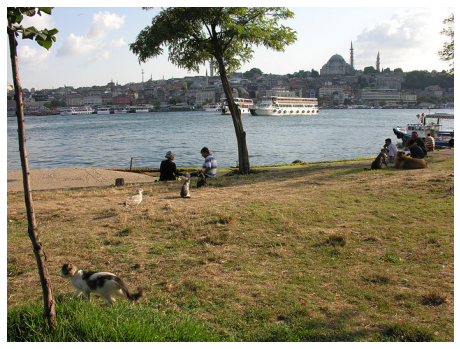

In [16]:
# load and display image

# sample_img = io.imread('%s/images/%s/%s'%(dataDir,dataType,sample_img_info['file_name']))
# 
# or
#
# # in f-string notation
# print(f"{dataDir}/images/{dataType}/{sample_img_info['file_name']}")
# sample_img = io.imread(f"{dataDir}/images/{dataType}/{sample_img_info['file_name']}")
#
# or
#
# use url to load image
sample_img = io.imread(sample_img_info['coco_url'])


plt.axis('off')
plt.imshow(sample_img)
plt.show()

In [40]:
help(coco.showAnns)

Help on method showAnns in module pycocotools.coco:

showAnns(anns, draw_bbox=False) method of pycocotools.coco.COCO instance
    Display the specified annotations.
    :param anns (array of object): annotations to display
    :return: None



10 objects of selected categories found on this image.


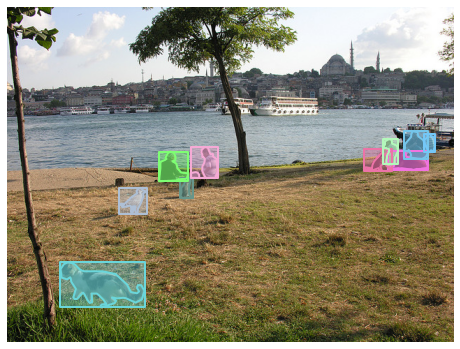

In [48]:
# load and display instance annotations for selected categories
plt.imshow(sample_img); plt.axis('off')
annIds = coco.getAnnIds(imgIds=sample_img_info['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
print(len(anns), 'objects of selected categories found on this image.')

In [49]:
for ann in anns:
    for key in ann:
        print(key, '\n\t', ann[key])
        print()
    print('-'*115)

segmentation 
	 [[551.87, 228.33, 552.86, 227.53, 554.26, 227.33, 554.26, 226.53, 554.26, 225.94, 555.32, 223.22, 555.15, 221.37, 556.5, 218.5, 556.16, 217.66, 555.99, 217.32, 555.82, 216.81, 555.49, 215.46, 555.65, 214.45, 556.67, 213.44, 557.34, 211.41, 557.34, 210.74, 557.85, 208.88, 558.02, 206.69, 558.02, 206.18, 560.55, 205.51, 562.74, 205.34, 563.58, 205.34, 565.44, 205.34, 569.15, 206.69, 569.66, 207.36, 570.33, 208.04, 570.5, 208.71, 570.5, 208.88, 570.84, 209.39, 571.01, 210.23, 571.18, 211.58, 571.51, 212.26, 571.85, 213.27, 572.53, 214.79, 574.89, 214.96, 577.59, 215.46, 579.11, 215.63, 583.83, 216.81, 599.02, 218.67, 599.35, 220.02, 599.52, 220.86, 600.7, 222.72, 601.04, 223.73, 601.38, 224.24, 602.22, 224.91, 602.05, 225.25, 602.05, 227.27, 602.05, 228.62, 601.38, 230.31, 599.52, 230.48, 594.46, 230.98, 592.6, 231.66, 590.41, 231.66, 588.56, 231.83, 586.53, 231.66, 582.14, 233.01, 578.43, 232.0, 576.24, 232.0, 571.68, 231.66, 571.35, 231.49, 565.1, 230.65, 562.23, 230.98,

19 objects of selected categories found on this image.


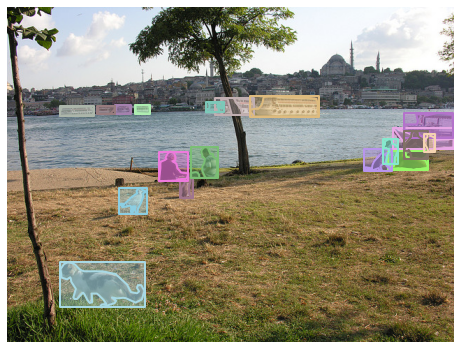

In [47]:
# load and display instance annotations for selected categories
plt.imshow(sample_img); plt.axis('off')
annIds = coco.getAnnIds(imgIds=sample_img_info['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
print(len(anns), 'objects of selected categories found on this image.')

In [45]:
for ann in anns:
    for key in ann:
        print(key, '\n\t', ann[key])
        print()
    print('-'*115)

segmentation 
	 [[551.87, 228.33, 552.86, 227.53, 554.26, 227.33, 554.26, 226.53, 554.26, 225.94, 555.32, 223.22, 555.15, 221.37, 556.5, 218.5, 556.16, 217.66, 555.99, 217.32, 555.82, 216.81, 555.49, 215.46, 555.65, 214.45, 556.67, 213.44, 557.34, 211.41, 557.34, 210.74, 557.85, 208.88, 558.02, 206.69, 558.02, 206.18, 560.55, 205.51, 562.74, 205.34, 563.58, 205.34, 565.44, 205.34, 569.15, 206.69, 569.66, 207.36, 570.33, 208.04, 570.5, 208.71, 570.5, 208.88, 570.84, 209.39, 571.01, 210.23, 571.18, 211.58, 571.51, 212.26, 571.85, 213.27, 572.53, 214.79, 574.89, 214.96, 577.59, 215.46, 579.11, 215.63, 583.83, 216.81, 599.02, 218.67, 599.35, 220.02, 599.52, 220.86, 600.7, 222.72, 601.04, 223.73, 601.38, 224.24, 602.22, 224.91, 602.05, 225.25, 602.05, 227.27, 602.05, 228.62, 601.38, 230.31, 599.52, 230.48, 594.46, 230.98, 592.6, 231.66, 590.41, 231.66, 588.56, 231.83, 586.53, 231.66, 582.14, 233.01, 578.43, 232.0, 576.24, 232.0, 571.68, 231.66, 571.35, 231.49, 565.1, 230.65, 562.23, 230.98,

In [54]:
# initialize COCO api for person keypoints annotations
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=2.74s)
creating index...
index created!


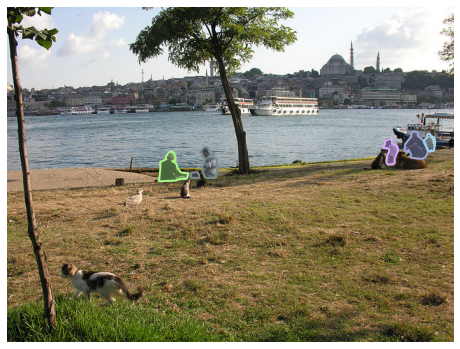

In [55]:
# load and display keypoints annotations
plt.imshow(sample_img); plt.axis('off')
ax = plt.gca()
annIds = coco_kps.getAnnIds(imgIds=sample_img_info['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)

In [56]:
# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


A cat and some people on a grass field.
A group of people sitting on a field next to a lake.
A group of people enjoying a water front view.
A group of people sitting around a lake with small animals.
People are sitting under a tree by the water.


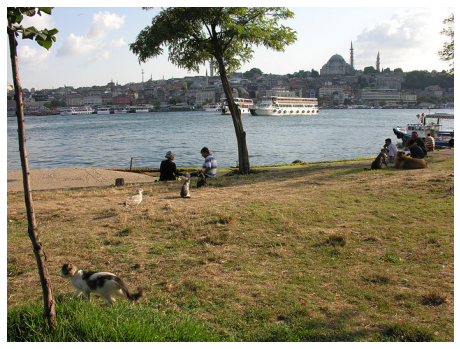

In [57]:
# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=sample_img_info['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(sample_img); plt.axis('off'); plt.show()